In [1]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import settings

In [2]:
development_data_path = f'{settings.raw_data_folder}control/country_development_data.csv'
targets_path = f'{settings.raw_data_folder}control/regression_targets.csv'

In [3]:
development_data = pd.read_csv(development_data_path)
development_data.head()

,Country,Obesity,Undernourished,Population,Annual Average Temperature,Max Latitude,Min Latitude,Max Longitude,Min Longitude,HDI Rank,...,gdp_2018,gdp_2019,code,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature
0,Afghanistan,0.037471,0.478109,0.027721,0.689775,0.602919,0.723203,0.700916,0.694015,0.893617,...,0.719723,0.876126,0.476531,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820
1,Albania,0.454333,0.064799,0.001985,0.671682,0.639673,0.806625,0.547690,0.575061,0.361702,...,0.820069,0.837838,0.713605,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493
2,Algeria,0.555035,0.024518,0.031592,0.888663,0.590785,0.638480,0.521881,0.494401,0.478723,...,0.726644,0.806306,0.000000,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447
3,Angola,0.091335,0.394046,0.023153,0.856803,0.226062,0.337267,0.556283,0.553128,0.781915,...,0.636678,0.768018,0.002383,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425
4,Antigua and Barbuda,0.379391,0.202945,0.000031,0.952521,0.420557,0.622284,0.312344,0.340846,0.409574,...,0.920415,0.864865,0.238265,0.000030,0.238265,0.020000,0.929101,0.842088,0.799537,0.961075


In [4]:
targets = pd.read_csv(targets_path)
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Deaths       0
Confirmed    0
Recovered    0
Country      0
dtype: int64


,Deaths,Confirmed,Recovered,Country
0,0.006186,0.142134,0.123374,Afghanistan
1,0.050951,2.967301,1.792636,Albania
2,0.006558,0.244897,0.167572,Algeria
3,0.001461,0.061687,0.056808,Angola
4,0.108227,4.356147,3.905192,Argentina


In [5]:
development_data = development_data.merge(targets, on='Country', how='inner')

In [6]:
label_values = ['Deaths', 'Recovered', 'Confirmed']
features_development = development_data.columns.drop(label_values)
features_development = features_development.drop(['Country', 'WHO code', 'FAO code'])

In [7]:
X_development = development_data[features_development]
Y_development = development_data[label_values]

In [8]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [174]:
def rfecv_shap_algorithm(estimator, X, Y, algorithm, step=1, score='neg_median_absolute_error'):
  shap_elimination = ShapRFECV(clf=estimator, step=step, cv=5, scoring=score, n_jobs=-1)
  shap_report = shap_elimination.fit_compute(X, Y)
  best_features_rfe_shap = shap_report[shap_report['val_metric_mean'] == shap_report['val_metric_mean'].max()]
  features_shap = list(best_features_rfe_shap['features_set'].values[0])
  features_shap_cv = {}
  features_shap_cv['algorithm'] = 'rfe - measure shap ' + algorithm
  features_shap_cv['selected_features'] = features_shap
  features_shap_cv['number_of_features'] = len(features_shap)
  features_shap_cv['neg_mae_score_cv'] = shap_report['val_metric_mean'].max()
  feat_shap = pd.DataFrame(features_shap_cv)
  feat_shap.to_csv(f'{settings.features_folder}selected_features_rfe_shap_' + algorithm + '.csv', index=False)
  return feat_shap

In [10]:
PARAMS = {
    'max_depth': [2, 3, 5],
    'min_child_weight': [3, 4, 5],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200, 250],
    'colsample_bytree': [1, 0.9, 0.8, 0.7]
}

In [11]:
xgb_development_params, xgb_development_score = hyper_parameter_search(X_development, Y_development['Deaths'], PARAMS)

In [12]:
print(f'best parameters: {xgb_development_params}')
print(f'score: {xgb_development_score}')

best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.25, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 35}
score: -0.023220903579509827


In [175]:
xgb_development = XGBRegressor(gamma = xgb_development_params['gamma'],
                               learning_rate = xgb_development_params['learning_rate'], 
                               max_depth = xgb_development_params['max_depth'],
                               min_child_weight = xgb_development_params['min_child_weight'], 
                               n_estimators = xgb_development_params['n_estimators'],
                               colsample_bytree = xgb_development_params['colsample_bytree'],
                               random_state=44)

In [176]:
rfecv_xgb_development = rfecv_shap_algorithm(xgb_development,
                                             X_development[X_development.columns.drop(['code'])], 
                                             Y_development['Deaths'], 
                                             'development')

In [177]:
rfecv_xgb_development

,algorithm,selected_features,number_of_features,neg_mae_score_cv
0,rfe - measure shap development,Max Latitude,3,-0.011
1,rfe - measure shap development,Obesity,3,-0.011
2,rfe - measure shap development,Annual Average Temperature,3,-0.011


In [178]:
selected_features_development = rfecv_xgb_development['selected_features']

In [179]:
X_train_development, X_test_development, Y_train_development, Y_test_development = train_test_split(
    X_development[selected_features_development],
    Y_development,
    test_size = 0.2,
    random_state=83
)

In [180]:
xgb_development.fit(X_train_development, Y_train_development['Deaths'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=5,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=35, n_jobs=8, num_parallel_tree=1, random_state=44,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [181]:
unscaled_data = pd.read_csv(f'{settings.raw_data_folder}control/control_data_unscaled.csv')

In [182]:
unscaled_data.dropna(inplace=True)

In [183]:
unscaled_data['Undernourished'] = [float(val) if val != '<2.5' else 2.5 for val in unscaled_data.Undernourished]

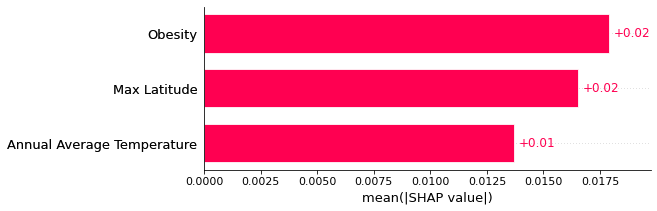

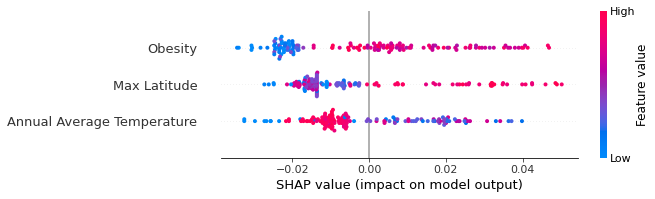

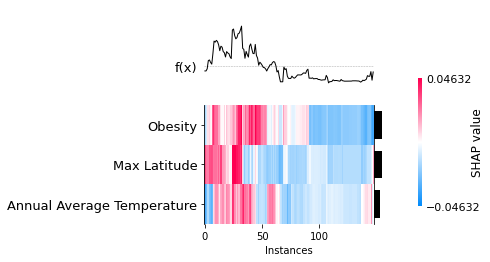

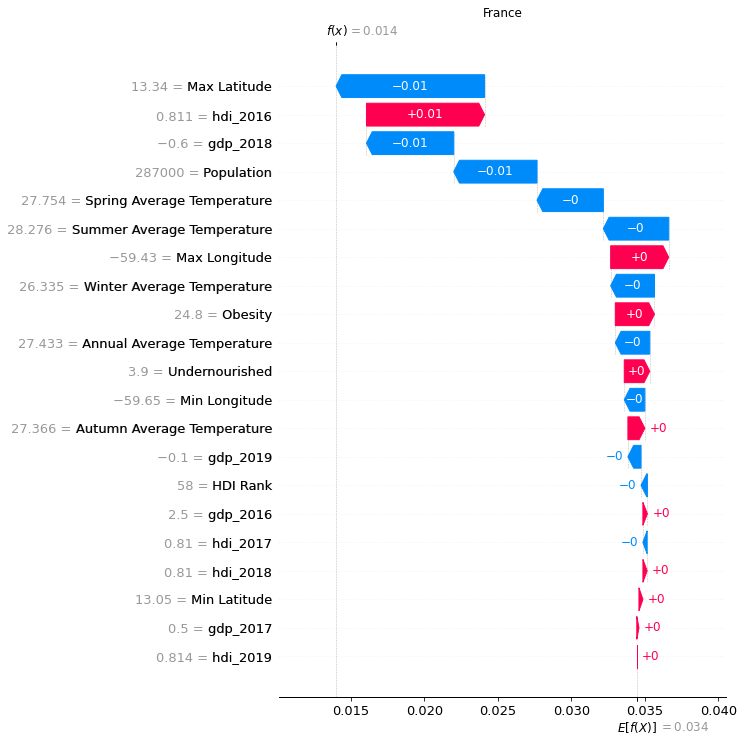

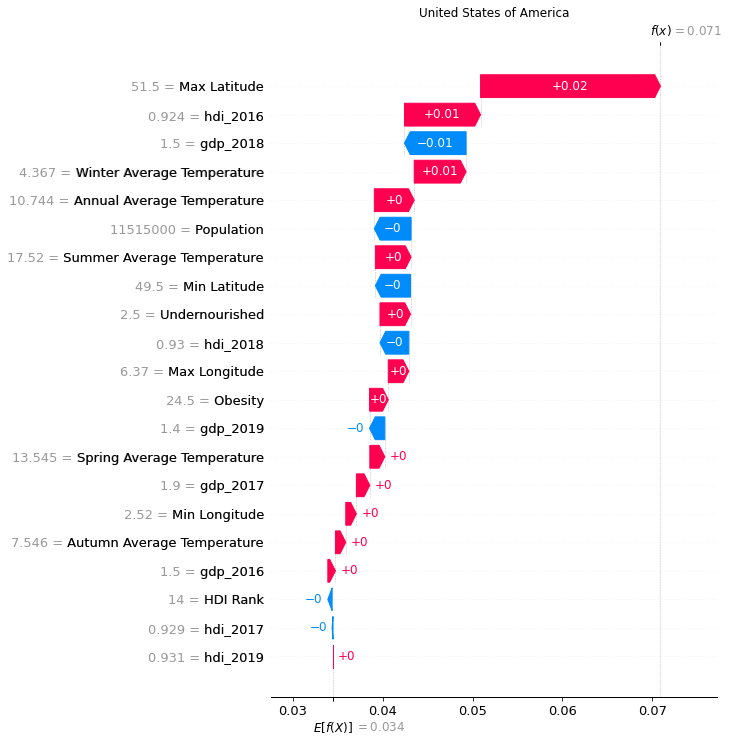

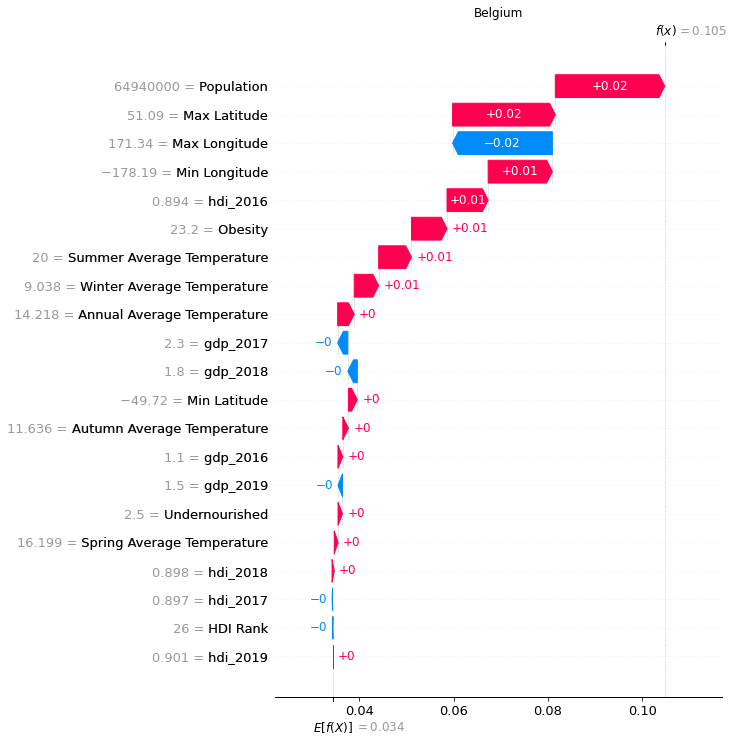

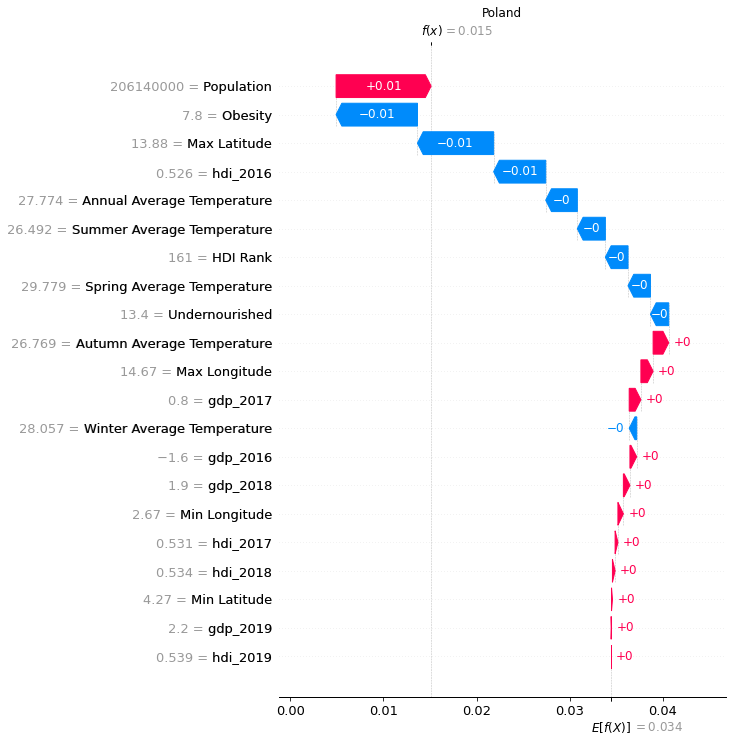

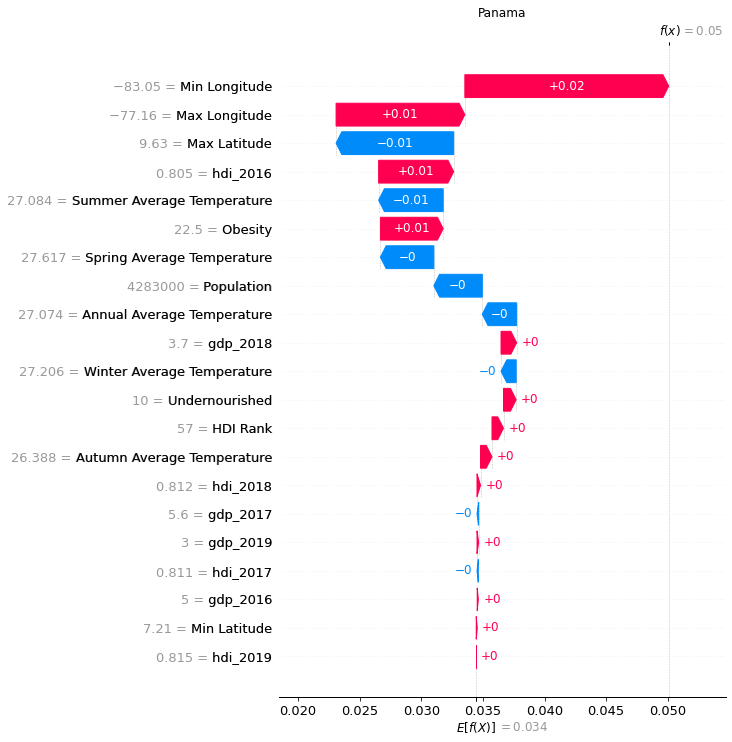

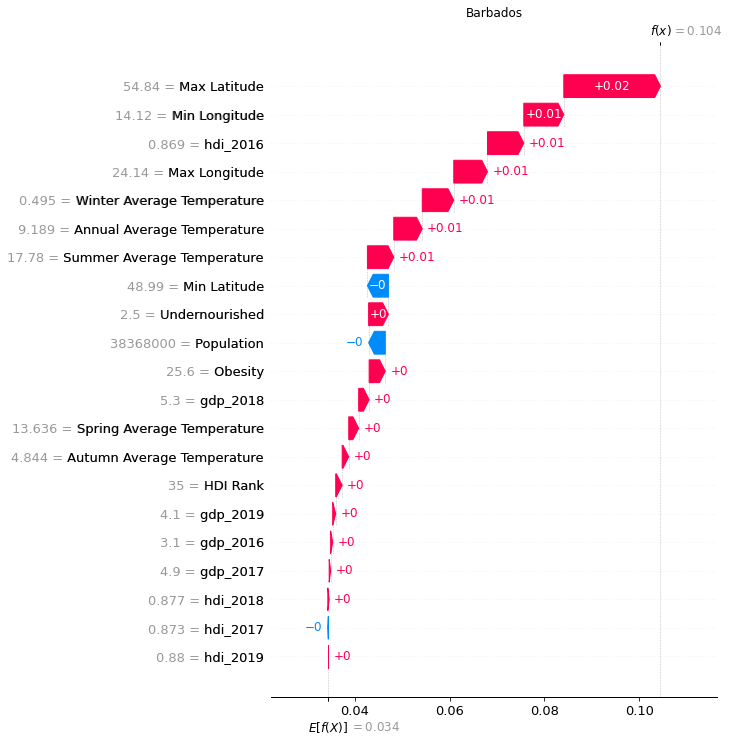

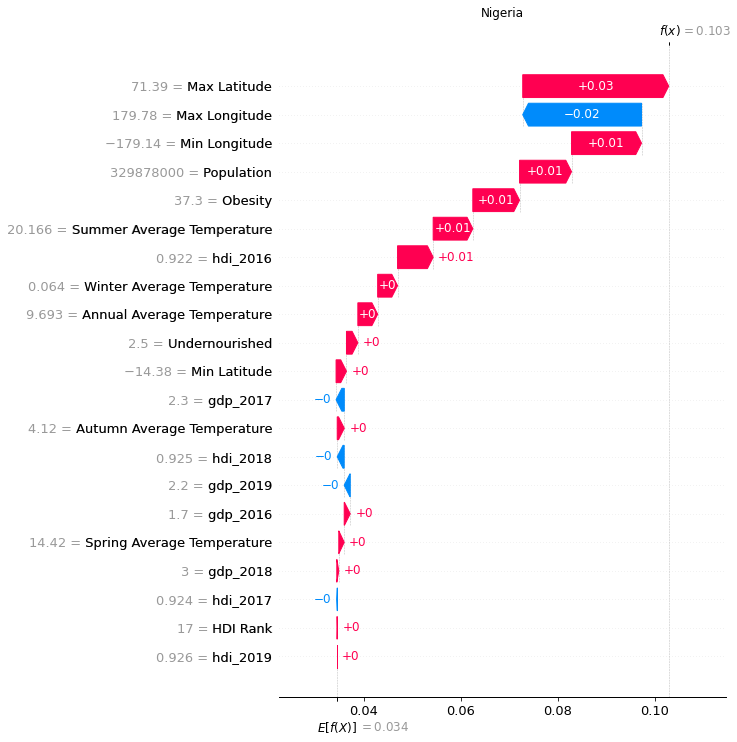

In [184]:
expl = shap.Explainer(xgb_development, X_development[selected_features_development])
shap_values = expl(X_development[selected_features_development])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)
shap.plots.heatmap(shap_values)

countries = ['France', 'United States of America', 'Belgium', 'Poland', 'Panama', 'Barbados', 'Nigeria']
unscaled_train = unscaled_data.merge(targets, on='Country', how='inner')
indices = unscaled_train[unscaled_train['Country'].isin(countries)].index.values
unscaled_t = unscaled_train.drop(indices)

X_unscaled = unscaled_t[unscaled_t.columns.drop(label_values)]
X_unscaled =  X_unscaled[X_unscaled.columns.drop('Country')] 
X_fin  = unscaled_train[unscaled_train.columns.drop(label_values)]
X_fin = X_fin[X_fin.columns.drop('Country')]

xgb_development.fit(X_unscaled, unscaled_t['Deaths'])
expl = shap.Explainer(xgb_development, X_fin)
shap_values = expl(X_fin)

for val, country in zip(indices, countries):
    plt.title(country)
    shap.plots.waterfall(shap_values[val], max_display=30)